In [1]:
import sqlite3
import pandas as pd
import numpy as np

from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt 
import seaborn as sns # Import seaborn

## Acquire data

Our data comes from a database file in SQLite format. We import it into a Pandas DataFrame for preprocessing. 

In [2]:
# open connection 
conn = sqlite3.connect("data/database.sqlite")
cur = conn.cursor()

In [3]:
# function to execute queries
def executeQuery(cur, query):
    print("executing query: ")
    cur.execute(query)
    return cur.fetchall()

In [4]:
# list of all tables
q_all_tables = """SELECT name FROM sqlite_master
    WHERE type='table';"""
all_tables = executeQuery(cur, q_all_tables)
# print(all_tables)


executing query: 


In [5]:
# read the Match table into Pandas DataFrame
q_matches = "SELECT * FROM MATCH;"
df_matches = pd.read_sql_query(q_matches, conn)


### Preprocessing Data
- we are dropping the columns that will not be needed for preliminary analysis

In [6]:
# do this only 1
# drop betting
df_matches = df_matches.drop(df_matches.iloc[:, 85:], axis=1)

#drop statistics
df_matches = df_matches.drop(df_matches.iloc[:, 77:], axis=1)

# drop X, Y positions
df_matches = df_matches.drop(df_matches.iloc[:, 11:55], axis=1)
# drop fifa_api_id and a couple other columns irrelevant
df_matches = df_matches.drop(df_matches.columns[[1, 2, 4]], axis=1)


In [7]:

df_matches.head()
# print(df_matches.shape)


,id,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
0,1,2008/2009,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2008/2009,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2008/2009,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2008/2009,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2008/2009,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# read the Match table into Pandas DataFrame
q_player = "SELECT * FROM PLAYER;"
df_player = pd.read_sql_query(q_player, conn)



In [9]:
# Drop player_fifa_api_id from player table
df_player = df_player.drop('player_fifa_api_id', axis=1)
df_player.tail()

,id,player_api_id,player_name,birthday,height,weight
11055,11071,26357,Zoumana Camara,1979-04-03 00:00:00,182.88,168
11056,11072,111182,Zsolt Laczko,1986-12-18 00:00:00,182.88,176
11057,11073,36491,Zsolt Low,1979-04-29 00:00:00,180.34,154
11058,11074,35506,Zurab Khizanishvili,1981-10-06 00:00:00,185.42,172
11059,11075,39902,Zvjezdan Misimovic,1982-06-05 00:00:00,180.34,176


In [10]:
# import data from player attribute table
q_player_attr = "SELECT * FROM Player_Attributes;"
df_player_attr = pd.read_sql_query(q_player_attr, conn)
df_player_attr = df_player_attr.loc[:, ['player_api_id', 'date', 'overall_rating']]

df_player_attr.tail(100)


,player_api_id,date,overall_rating
183878,99031,2015-09-25 00:00:00,80.0
183879,99031,2015-09-21 00:00:00,80.0
183880,99031,2015-04-10 00:00:00,78.0
183881,99031,2014-09-18 00:00:00,78.0
183882,99031,2014-05-09 00:00:00,76.0
...,...,...,...
183973,39902,2009-08-30 00:00:00,83.0
183974,39902,2009-02-22 00:00:00,78.0
183975,39902,2008-08-30 00:00:00,77.0
183976,39902,2007-08-30 00:00:00,78.0


In [11]:
# import team name
q_team = "SELECT * FROM Team"
df_team = pd.read_sql_query(q_team, conn)
df_team = df_team.loc[:, ['team_api_id', 'team_long_name', 'team_short_name']]

df_team.tail(10)


,team_api_id,team_long_name,team_short_name
289,10179,FC Sion,SIO
290,10199,FC Luzern,LUZ
291,9824,FC Vaduz,VAD
292,7955,Neuchâtel Xamax,XAM
293,10243,FC Zürich,ZUR
294,10190,FC St. Gallen,GAL
295,10191,FC Thun,THU
296,9777,Servette FC,SER
297,7730,FC Lausanne-Sports,LAU
298,7896,Lugano,LUG


In [12]:
# import Country but wont use them they dont add value to the model
q_country = "SELECT * FROM Country"
df_country = pd.read_sql_query(q_country, conn)
df_country.tail()


,id,name
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain
10,24558,Switzerland


In [13]:
# import League but wont use them they dont add value to the model
q_league = "SELECT * FROM League"
df_league = pd.read_sql_query(q_league, conn)
df_league.tail()

,id,country_id,name
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA
10,24558,24558,Switzerland Super League


In [14]:
# import Team_Attributes but wont use them they dont add value to the model
q_team_attr = "SELECT * FROM Team_Attributes"
df_team_attr = pd.read_sql_query(q_team_attr, conn)
df_team_attr.tail()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
1453,1454,15005,10000,2011-02-22 00:00:00,52,Balanced,NaN,Little,52,Mixed,...,53,Normal,Organised,46,Medium,48,Press,53,Normal,Cover
1454,1455,15005,10000,2012-02-22 00:00:00,54,Balanced,NaN,Little,51,Mixed,...,50,Normal,Organised,44,Medium,55,Press,53,Normal,Cover
1455,1456,15005,10000,2013-09-20 00:00:00,54,Balanced,NaN,Little,51,Mixed,...,32,Little,Organised,44,Medium,58,Press,37,Normal,Cover
1456,1457,15005,10000,2014-09-19 00:00:00,54,Balanced,42.0,Normal,51,Mixed,...,32,Little,Organised,44,Medium,58,Press,37,Normal,Cover
1457,1458,15005,10000,2015-09-10 00:00:00,54,Balanced,42.0,Normal,51,Mixed,...,32,Little,Organised,44,Medium,58,Press,37,Normal,Cover


## Consolidating features from Matches, Players, and other dataframes into a single DF
This is the basis for model building 

In [15]:
df_main = df_matches
df_main.tail()



,id,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1,home_player_2,...,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11
25974,25975,2015/2016,2015-09-22 00:00:00,1992091,10190,10191,1,0,42231.0,678384.0,...,563066.0,8800.0,67304.0,158253.0,133126.0,186524.0,93223.0,121115.0,232110.0,289732.0
25975,25976,2015/2016,2015-09-23 00:00:00,1992092,9824,10199,1,2,33272.0,41621.0,...,114792.0,150007.0,178119.0,27232.0,570830.0,260708.0,201704.0,36382.0,34082.0,95257.0
25976,25977,2015/2016,2015-09-23 00:00:00,1992093,9956,10179,2,0,157856.0,274779.0,...,67349.0,202663.0,32597.0,114794.0,188114.0,25840.0,482200.0,95230.0,451335.0,275122.0
25977,25978,2015/2016,2015-09-22 00:00:00,1992094,7896,10243,0,0,NaN,8881.0,...,121080.0,197757.0,260964.0,231614.0,113235.0,41116.0,462608.0,42262.0,92252.0,194532.0
25978,25979,2015/2016,2015-09-23 00:00:00,1992095,10192,9931,4,3,274787.0,492132.0,...,95216.0,172768.0,22834.0,458806.0,207234.0,25772.0,40274.0,34035.0,41726.0,527103.0


## Feb 22, Join player name into main_df


In [16]:
print(df_main.shape)

(25979, 30)


In [17]:

# NB RUN THIS CODE ONLY ONCE or restart needed
df_main = df_main.rename(columns={"id":"id_main"})
df_player = df_player.rename(columns={"id":"id_player"})

hp = 'home_player_'
for i in range(1, 12):
    hp_n = hp+str(i)
    df_main = df_main.set_index(hp_n).join(df_player.set_index('player_api_id'))
    df_main = df_main.rename(columns={"id_player": hp_n+"_id", "player_name": hp_n+"_name", "birthday": hp_n+"_birthday", "height":hp_n+"_height", "weight":hp_n+"_weight"})

ap = 'away_player_'
for i in range(1, 12):
    ap_n = ap+str(i)
    df_main = df_main.set_index(ap_n).join(df_player.set_index('player_api_id'))
    df_main = df_main.rename(columns={"id_player": ap_n+"_id", "player_name": ap_n+"_name", "birthday": ap_n+"_birthday", "height":ap_n+"_height", "weight":ap_n+"_weight"})


In [18]:
print(df_main.shape)
print()

(25979, 118)



In [19]:
df_main.info()
df_main.tail(100)

<class 'pandas.core.frame.DataFrame'>
Float64Index: 25979 entries, 2802.0 to nan
Columns: 118 entries, id_main to away_player_11_weight
dtypes: float64(66), int64(6), object(46)
memory usage: 23.6+ MB


,id_main,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1_id,home_player_1_name,...,away_player_10_id,away_player_10_name,away_player_10_birthday,away_player_10_height,away_player_10_weight,away_player_11_id,away_player_11_name,away_player_11_birthday,away_player_11_height,away_player_11_weight
NaN,24562,2008/2009,2008-07-20 00:00:00,486266,7955,10243,1,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,24563,2008/2009,2008-09-26 00:00:00,486310,6493,9956,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,24564,2008/2009,2008-09-27 00:00:00,486311,9931,10192,1,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,24565,2008/2009,2008-09-27 00:00:00,486312,10179,9930,1,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,24566,2008/2009,2008-09-28 00:00:00,486313,9824,10199,1,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,24733,2008/2009,2008-09-13 00:00:00,486305,9931,10199,2,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,24734,2008/2009,2008-09-13 00:00:00,486306,9956,9930,0,0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,24735,2008/2009,2008-09-13 00:00:00,486307,7955,10179,3,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NaN,24736,2008/2009,2008-09-14 00:00:00,486308,6493,10192,1,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
no_nans = df_main[~df_main.isnull().any(axis=1)]
print(no_nans.shape)
no_nans.tail()

(21374, 118)


,id_main,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1_id,home_player_1_name,...,away_player_10_id,away_player_10_name,away_player_10_birthday,away_player_10_height,away_player_10_weight,away_player_11_id,away_player_11_name,away_player_11_birthday,away_player_11_height,away_player_11_weight
717557.0,15628,2015/2016,2016-04-10 00:00:00,1983538,10228,10229,4,2,3101.0,Erwin Mulder,...,10644.0,Vincent Janssen,1994-06-15 00:00:00,182.88,176.0,6118.0,Levi Garcia,1997-11-20 00:00:00,175.26,159.0
725718.0,15656,2015/2016,2016-05-01 00:00:00,1983566,9791,10217,1,1,1355.0,Bram Castro,...,7532.0,Mike Havenaar,1987-05-20 00:00:00,193.04,179.0,2571.0,Dennis van der Heijden,1997-02-17 00:00:00,193.04,165.0
726956.0,25875,2015/2016,2016-04-13 00:00:00,1992161,7896,9931,1,4,7609.0,Mirko Salvi,...,1276.0,Birkir Bjarnason,1988-05-27 00:00:00,182.88,165.0,1619.0,Cedric Itten,1996-12-27 00:00:00,185.42,176.0
726956.0,25943,2015/2016,2016-05-22 00:00:00,1992224,10192,9931,2,3,11005.0,Yvon Mvogo,...,8872.0,Renato Steffen,1991-11-03 00:00:00,170.18,150.0,1619.0,Cedric Itten,1996-12-27 00:00:00,185.42,176.0
726956.0,25918,2015/2016,2016-04-24 00:00:00,1992199,9824,9931,0,0,8560.0,Peter Jehle,...,1380.0,Breel Embolo,1997-02-14 00:00:00,185.42,185.0,1619.0,Cedric Itten,1996-12-27 00:00:00,185.42,176.0


In [21]:
# calculate age
pd.options.mode.chained_assignment = None
df_main_nn = no_nans

hp = 'home_player_'
ap = 'away_player_'
for i in range(1, 12):
    hp_n = hp+str(i)
    ap_n = ap+str(i)
    df_main_nn['date'] = pd.to_datetime(df_main_nn['date'])
    df_main_nn[hp_n+"_birthday"] = pd.to_datetime(df_main_nn[hp_n+"_birthday"])
    df_main_nn[ap_n+"_birthday"] = pd.to_datetime(df_main_nn[ap_n+"_birthday"])
    
    df_main_nn[hp_n+"_age"] = (df_main_nn['date'].dt.year - df_main_nn[hp_n+"_birthday"].dt.year)
    df_main_nn[ap_n+"_age"] = (df_main_nn['date'].dt.year - df_main_nn[ap_n+"_birthday"].dt.year)   

In [22]:
df_main_nn = no_nans
print(df_main_nn.shape)
pd.options.display.max_columns = None
df_main_nn.tail()

(21374, 140)


,id_main,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1_id,home_player_1_name,home_player_1_birthday,home_player_1_height,home_player_1_weight,home_player_2_id,home_player_2_name,home_player_2_birthday,home_player_2_height,home_player_2_weight,home_player_3_id,home_player_3_name,home_player_3_birthday,home_player_3_height,home_player_3_weight,home_player_4_id,home_player_4_name,home_player_4_birthday,home_player_4_height,home_player_4_weight,home_player_5_id,home_player_5_name,home_player_5_birthday,home_player_5_height,home_player_5_weight,home_player_6_id,home_player_6_name,home_player_6_birthday,home_player_6_height,home_player_6_weight,home_player_7_id,home_player_7_name,home_player_7_birthday,home_player_7_height,home_player_7_weight,home_player_8_id,home_player_8_name,home_player_8_birthday,home_player_8_height,home_player_8_weight,home_player_9_id,home_player_9_name,home_player_9_birthday,home_player_9_height,home_player_9_weight,home_player_10_id,home_player_10_name,home_player_10_birthday,home_player_10_height,home_player_10_weight,home_player_11_id,home_player_11_name,home_player_11_birthday,home_player_11_height,home_player_11_weight,away_player_1_id,away_player_1_name,away_player_1_birthday,away_player_1_height,away_player_1_weight,away_player_2_id,away_player_2_name,away_player_2_birthday,away_player_2_height,away_player_2_weight,away_player_3_id,away_player_3_name,away_player_3_birthday,away_player_3_height,away_player_3_weight,away_player_4_id,away_player_4_name,away_player_4_birthday,away_player_4_height,away_player_4_weight,away_player_5_id,away_player_5_name,away_player_5_birthday,away_player_5_height,away_player_5_weight,away_player_6_id,away_player_6_name,away_player_6_birthday,away_player_6_height,away_player_6_weight,away_player_7_id,away_player_7_name,away_player_7_birthday,away_player_7_height,away_player_7_weight,away_player_8_id,away_player_8_name,away_player_8_birthday,away_player_8_height,away_player_8_weight,away_player_9_id,away_player_9_name,away_player_9_birthday,away_player_9_height,away_player_9_weight,away_player_10_id,away_player_10_name,away_player_10_birthday,away_player_10_height,away_player_10_weight,away_player_11_id,away_player_11_name,away_player_11_birthday,away_player_11_height,away_player_11_weight,home_player_1_age,away_player_1_age,home_player_2_age,away_player_2_age,home_player_3_age,away_player_3_age,home_player_4_age,away_player_4_age,home_player_5_age,away_player_5_age,home_player_6_age,away_player_6_age,home_player_7_age,away_player_7_age,home_player_8_age,away_player_8_age,home_player_9_age,away_player_9_age,home_player_10_age,away_player_10_age,home_player_11_age,away_player_11_age
717557.0,15628,2015/2016,2016-04-10,1983538,10228,10229,4,2,3101.0,Erwin Mulder,1989-03-03,193.04,194.0,9935.0,Stefano Marzo,1991-03-22,180.34,159.0,5225.0,Joost van Aken,1994-05-13,193.04,165.0,5718.0,Kenny Otigba,1992-08-29,187.96,185.0,6278.0,Lucas Bijker,1993-03-04,175.26,163.0,4900.0,Jerry St. Juste,1996-10-19,185.42,157.0,5071.0,Joey van den Berg,1986-02-13,182.88,170.0,1360.0,Branco van den Boomen,1995-07-21,190.50,183.0,933.0,Arber Zeneli,1995-02-25,175.26,159.0,7633.0,Mitchell te Vrede,1991-08-07,193.04,183.0,9409.0,Sam Larsson,1993-04-10,180.34,168.0,9701.0,Sergio Rochet,1993-03-23,190.50,176.0,2586.0,Derrick Luckassen,1995-07-03,185.42,165.0,9210.0,Ron Vlaar,1985-02-16,187.96,174.0,10070.0,Stijn Wuytens,1989-10-08,182.88,170.0,8989.0,Ridgeciano Haps,1993-06-12,175.26,146.0,10210.0,Thom Haye,1995-02-09,177.80,163.0,6920.0,Markus Henriksen,1992-07-25,187.96,172.0,5299.0,Joris van Overeem,1994-07-01,180.34,157.0,531.0,Alireza Jahanbakhsh,1993-10-08,180.34,165.0,10644.0,Vincent Janssen,1994-06-15,182.88,176.0,6118.0,Levi Garcia,1997-11-20,175.26,159.0,27,23,25,21,22,31,24,27,23,23,20,21,30,24,21,22,21,23,25,22,23,19
725718.0,15656,2015/2016,2016-05-01,1983566,9791,10217,1,1,1355.0,Bram Castro,1982-09-30,190.50,183.0,9088.0,Robin Gose

In [23]:
df_main_nn.head()

,id_main,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1_id,home_player_1_name,home_player_1_birthday,home_player_1_height,home_player_1_weight,home_player_2_id,home_player_2_name,home_player_2_birthday,home_player_2_height,home_player_2_weight,home_player_3_id,home_player_3_name,home_player_3_birthday,home_player_3_height,home_player_3_weight,home_player_4_id,home_player_4_name,home_player_4_birthday,home_player_4_height,home_player_4_weight,home_player_5_id,home_player_5_name,home_player_5_birthday,home_player_5_height,home_player_5_weight,home_player_6_id,home_player_6_name,home_player_6_birthday,home_player_6_height,home_player_6_weight,home_player_7_id,home_player_7_name,home_player_7_birthday,home_player_7_height,home_player_7_weight,home_player_8_id,home_player_8_name,home_player_8_birthday,home_player_8_height,home_player_8_weight,home_player_9_id,home_player_9_name,home_player_9_birthday,home_player_9_height,home_player_9_weight,home_player_10_id,home_player_10_name,home_player_10_birthday,home_player_10_height,home_player_10_weight,home_player_11_id,home_player_11_name,home_player_11_birthday,home_player_11_height,home_player_11_weight,away_player_1_id,away_player_1_name,away_player_1_birthday,away_player_1_height,away_player_1_weight,away_player_2_id,away_player_2_name,away_player_2_birthday,away_player_2_height,away_player_2_weight,away_player_3_id,away_player_3_name,away_player_3_birthday,away_player_3_height,away_player_3_weight,away_player_4_id,away_player_4_name,away_player_4_birthday,away_player_4_height,away_player_4_weight,away_player_5_id,away_player_5_name,away_player_5_birthday,away_player_5_height,away_player_5_weight,away_player_6_id,away_player_6_name,away_player_6_birthday,away_player_6_height,away_player_6_weight,away_player_7_id,away_player_7_name,away_player_7_birthday,away_player_7_height,away_player_7_weight,away_player_8_id,away_player_8_name,away_player_8_birthday,away_player_8_height,away_player_8_weight,away_player_9_id,away_player_9_name,away_player_9_birthday,away_player_9_height,away_player_9_weight,away_player_10_id,away_player_10_name,away_player_10_birthday,away_player_10_height,away_player_10_weight,away_player_11_id,away_player_11_name,away_player_11_birthday,away_player_11_height,away_player_11_weight,home_player_1_age,away_player_1_age,home_player_2_age,away_player_2_age,home_player_3_age,away_player_3_age,home_player_4_age,away_player_4_age,home_player_5_age,away_player_5_age,home_player_6_age,away_player_6_age,home_player_7_age,away_player_7_age,home_player_8_age,away_player_8_age,home_player_9_age,away_player_9_age,home_player_10_age,away_player_10_age,home_player_11_age,away_player_11_age
2802.0,3391,2012/2013,2013-01-12,1229331,8668,10003,0,0,10301.0,Tim Howard,1979-03-06,190.50,194.0,9552.0,Seamus Coleman,1988-10-11,177.80,170.0,8588.0,Phil Jagielka,1982-08-17,182.88,183.0,10118.0,Sylvain Distin,1977-12-16,193.04,194.0,6060.0,Leighton Baines,1984-12-11,170.18,154.0,10604.0,Victor Anichebe,1988-04-23,185.42,176.0,8593.0,Philip Neville,1977-01-21,180.34,168.0,6087.0,Leon Osman,1981-05-17,172.72,141.0,10046.0,Steven Pienaar,1982-03-17,170.18,146.0,6940.0,Marouane Fellaini,1987-11-22,193.04,187.0,7991.0,Nikica Jelavic,1985-08-27,187.96,185.0,7442.0,Michel Vorm,1983-10-20,182.88,190.0,2819.0,Dwight Tiendalli,1985-10-21,175.26,161.0,1023.0,Ashley Williams,1984-08-23,182.88,201.0,1695.0,Chico,1987-03-06,187.96,165.0,1164.0,Ben Davies,1993-04-24,180.34,157.0,803.0,Angel Rangel,1982-10-28,180.34,181.0,10101.0,Sung-Yueng Ki,1989-01-24,185.42,165.0,5696.0,Kemy Agustien,1986-08-20,177.80,165.0,7798.0,Nathan Dyer,1987-11-29,167.64,137.0,7462.0,Michu,1986-03-21,185.42,176.0,8249.0,Pablo Hernandez,1985-04-11,172.72,159.0,34,30,25,28,31,29,36,26,29,20,25,31,36,24,32,27,31,26,26,27,28,28
2802.0,3441,2012/2013,2013-02-17,1229387,8650,10003,5,0,8541.0,Pepe Reina,1982-08-31,187.96,203.0,3905.0,Glen Johnson,1984-08-23,182.88,154.0,4609.0,Jamie

In [24]:
# Average Height for teams

hp = 'home_player_'
hp_col_list_height = [hp+str(i)+'_height' for i in range(1,12)] 
print(hp_col_list_height)    

ap = 'away_player_'
ap_col_list_height = [ap+str(i)+'_height' for i in range(1,12)] 
print(ap_col_list_height)   

df_main_nn[hp+'height_total'] = df_main_nn[hp_col_list_height].sum(axis=1)
df_main_nn[ap+'height_total'] = df_main_nn[ap_col_list_height].sum(axis=1)



['home_player_1_height', 'home_player_2_height', 'home_player_3_height', 'home_player_4_height', 'home_player_5_height', 'home_player_6_height', 'home_player_7_height', 'home_player_8_height', 'home_player_9_height', 'home_player_10_height', 'home_player_11_height']
['away_player_1_height', 'away_player_2_height', 'away_player_3_height', 'away_player_4_height', 'away_player_5_height', 'away_player_6_height', 'away_player_7_height', 'away_player_8_height', 'away_player_9_height', 'away_player_10_height', 'away_player_11_height']


In [25]:
# Average Weight for teams

hp = 'home_player_'
hp_col_list_weight = [hp+str(i)+'_weight' for i in range(1,12)] 
hp_col_list_age = [hp+str(i)+'_age' for i in range(1,12)] 
print(hp_col_list_weight)    

ap = 'away_player_'
ap_col_list_weight = [ap+str(i)+'_weight' for i in range(1,12)]
ap_col_list_age = [ap+str(i)+'_age' for i in range(1,12)] 
print(ap_col_list_weight)   

df_main_nn[hp+'weight_total'] = df_main_nn[hp_col_list_weight].sum(axis=1)
df_main_nn[ap+'weight_total'] = df_main_nn[ap_col_list_weight].sum(axis=1)

df_main_nn[hp+'age_total'] = df_main_nn[hp_col_list_age].sum(axis=1)
df_main_nn[ap+'age_total'] = df_main_nn[ap_col_list_age].sum(axis=1)

df_main_nn[hp+'age_average'] = (df_main_nn[hp+'age_total']/11)
df_main_nn[ap+'age_average'] = (df_main_nn[ap+'age_total']/11)


['home_player_1_weight', 'home_player_2_weight', 'home_player_3_weight', 'home_player_4_weight', 'home_player_5_weight', 'home_player_6_weight', 'home_player_7_weight', 'home_player_8_weight', 'home_player_9_weight', 'home_player_10_weight', 'home_player_11_weight']
['away_player_1_weight', 'away_player_2_weight', 'away_player_3_weight', 'away_player_4_weight', 'away_player_5_weight', 'away_player_6_weight', 'away_player_7_weight', 'away_player_8_weight', 'away_player_9_weight', 'away_player_10_weight', 'away_player_11_weight']


In [26]:
# calculate BMI for teams 
df_main_nn['home_team_bmi'] = ((df_main_nn['home_player_weight_total']/2.20462)/((df_main_nn['home_player_height_total']/100)**2))*11
df_main_nn['away_team_bmi'] = ((df_main_nn['away_player_weight_total']/2.20462)/((df_main_nn['away_player_height_total']/100)**2))*11

In [27]:
df_main_nn.tail()

,id_main,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1_id,home_player_1_name,home_player_1_birthday,home_player_1_height,home_player_1_weight,home_player_2_id,home_player_2_name,home_player_2_birthday,home_player_2_height,home_player_2_weight,home_player_3_id,home_player_3_name,home_player_3_birthday,home_player_3_height,home_player_3_weight,home_player_4_id,home_player_4_name,home_player_4_birthday,home_player_4_height,home_player_4_weight,home_player_5_id,home_player_5_name,home_player_5_birthday,home_player_5_height,home_player_5_weight,home_player_6_id,home_player_6_name,home_player_6_birthday,home_player_6_height,home_player_6_weight,home_player_7_id,home_player_7_name,home_player_7_birthday,home_player_7_height,home_player_7_weight,home_player_8_id,home_player_8_name,home_player_8_birthday,home_player_8_height,home_player_8_weight,home_player_9_id,home_player_9_name,home_player_9_birthday,home_player_9_height,home_player_9_weight,home_player_10_id,home_player_10_name,home_player_10_birthday,home_player_10_height,home_player_10_weight,home_player_11_id,home_player_11_name,home_player_11_birthday,home_player_11_height,home_player_11_weight,away_player_1_id,away_player_1_name,away_player_1_birthday,away_player_1_height,away_player_1_weight,away_player_2_id,away_player_2_name,away_player_2_birthday,away_player_2_height,away_player_2_weight,away_player_3_id,away_player_3_name,away_player_3_birthday,away_player_3_height,away_player_3_weight,away_player_4_id,away_player_4_name,away_player_4_birthday,away_player_4_height,away_player_4_weight,away_player_5_id,away_player_5_name,away_player_5_birthday,away_player_5_height,away_player_5_weight,away_player_6_id,away_player_6_name,away_player_6_birthday,away_player_6_height,away_player_6_weight,away_player_7_id,away_player_7_name,away_player_7_birthday,away_player_7_height,away_player_7_weight,away_player_8_id,away_player_8_name,away_player_8_birthday,away_player_8_height,away_player_8_weight,away_player_9_id,away_player_9_name,away_player_9_birthday,away_player_9_height,away_player_9_weight,away_player_10_id,away_player_10_name,away_player_10_birthday,away_player_10_height,away_player_10_weight,away_player_11_id,away_player_11_name,away_player_11_birthday,away_player_11_height,away_player_11_weight,home_player_1_age,away_player_1_age,home_player_2_age,away_player_2_age,home_player_3_age,away_player_3_age,home_player_4_age,away_player_4_age,home_player_5_age,away_player_5_age,home_player_6_age,away_player_6_age,home_player_7_age,away_player_7_age,home_player_8_age,away_player_8_age,home_player_9_age,away_player_9_age,home_player_10_age,away_player_10_age,home_player_11_age,away_player_11_age,home_player_height_total,away_player_height_total,home_player_weight_total,away_player_weight_total,home_player_age_total,away_player_age_total,home_player_age_average,away_player_age_average,home_team_bmi,away_team_bmi
717557.0,15628,2015/2016,2016-04-10,1983538,10228,10229,4,2,3101.0,Erwin Mulder,1989-03-03,193.04,194.0,9935.0,Stefano Marzo,1991-03-22,180.34,159.0,5225.0,Joost van Aken,1994-05-13,193.04,165.0,5718.0,Kenny Otigba,1992-08-29,187.96,185.0,6278.0,Lucas Bijker,1993-03-04,175.26,163.0,4900.0,Jerry St. Juste,1996-10-19,185.42,157.0,5071.0,Joey van den Berg,1986-02-13,182.88,170.0,1360.0,Branco van den Boomen,1995-07-21,190.50,183.0,933.0,Arber Zeneli,1995-02-25,175.26,159.0,7633.0,Mitchell te Vrede,1991-08-07,193.04,183.0,9409.0,Sam Larsson,1993-04-10,180.34,168.0,9701.0,Sergio Rochet,1993-03-23,190.50,176.0,2586.0,Derrick Luckassen,1995-07-03,185.42,165.0,9210.0,Ron Vlaar,1985-02-16,187.96,174.0,10070.0,Stijn Wuytens,1989-10-08,182.88,170.0,8989.0,Ridgeciano Haps,1993-06-12,175.26,146.0,10210.0,Thom Haye,1995-02-09,177.80,163.0,6920.0,Markus Henriksen,1992-07-25,187.96,172.0,5299.0,Joris van Overeem,1994-07-01,180.34,157.0,531.0,Alireza Jahanbakhsh,1993-10-08,180.34,165.0,10644.0,Vincent Janssen,1994-06-15,182.88,176.0,6118.0,L

In [28]:
df_main_nn['outcome'] = (df_main_nn["home_team_goal"] > df_main_nn["away_team_goal"])

In [29]:
df_main_nn.tail()

,id_main,season,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_1_id,home_player_1_name,home_player_1_birthday,home_player_1_height,home_player_1_weight,home_player_2_id,home_player_2_name,home_player_2_birthday,home_player_2_height,home_player_2_weight,home_player_3_id,home_player_3_name,home_player_3_birthday,home_player_3_height,home_player_3_weight,home_player_4_id,home_player_4_name,home_player_4_birthday,home_player_4_height,home_player_4_weight,home_player_5_id,home_player_5_name,home_player_5_birthday,home_player_5_height,home_player_5_weight,home_player_6_id,home_player_6_name,home_player_6_birthday,home_player_6_height,home_player_6_weight,home_player_7_id,home_player_7_name,home_player_7_birthday,home_player_7_height,home_player_7_weight,home_player_8_id,home_player_8_name,home_player_8_birthday,home_player_8_height,home_player_8_weight,home_player_9_id,home_player_9_name,home_player_9_birthday,home_player_9_height,home_player_9_weight,home_player_10_id,home_player_10_name,home_player_10_birthday,home_player_10_height,home_player_10_weight,home_player_11_id,home_player_11_name,home_player_11_birthday,home_player_11_height,home_player_11_weight,away_player_1_id,away_player_1_name,away_player_1_birthday,away_player_1_height,away_player_1_weight,away_player_2_id,away_player_2_name,away_player_2_birthday,away_player_2_height,away_player_2_weight,away_player_3_id,away_player_3_name,away_player_3_birthday,away_player_3_height,away_player_3_weight,away_player_4_id,away_player_4_name,away_player_4_birthday,away_player_4_height,away_player_4_weight,away_player_5_id,away_player_5_name,away_player_5_birthday,away_player_5_height,away_player_5_weight,away_player_6_id,away_player_6_name,away_player_6_birthday,away_player_6_height,away_player_6_weight,away_player_7_id,away_player_7_name,away_player_7_birthday,away_player_7_height,away_player_7_weight,away_player_8_id,away_player_8_name,away_player_8_birthday,away_player_8_height,away_player_8_weight,away_player_9_id,away_player_9_name,away_player_9_birthday,away_player_9_height,away_player_9_weight,away_player_10_id,away_player_10_name,away_player_10_birthday,away_player_10_height,away_player_10_weight,away_player_11_id,away_player_11_name,away_player_11_birthday,away_player_11_height,away_player_11_weight,home_player_1_age,away_player_1_age,home_player_2_age,away_player_2_age,home_player_3_age,away_player_3_age,home_player_4_age,away_player_4_age,home_player_5_age,away_player_5_age,home_player_6_age,away_player_6_age,home_player_7_age,away_player_7_age,home_player_8_age,away_player_8_age,home_player_9_age,away_player_9_age,home_player_10_age,away_player_10_age,home_player_11_age,away_player_11_age,home_player_height_total,away_player_height_total,home_player_weight_total,away_player_weight_total,home_player_age_total,away_player_age_total,home_player_age_average,away_player_age_average,home_team_bmi,away_team_bmi,outcome
717557.0,15628,2015/2016,2016-04-10,1983538,10228,10229,4,2,3101.0,Erwin Mulder,1989-03-03,193.04,194.0,9935.0,Stefano Marzo,1991-03-22,180.34,159.0,5225.0,Joost van Aken,1994-05-13,193.04,165.0,5718.0,Kenny Otigba,1992-08-29,187.96,185.0,6278.0,Lucas Bijker,1993-03-04,175.26,163.0,4900.0,Jerry St. Juste,1996-10-19,185.42,157.0,5071.0,Joey van den Berg,1986-02-13,182.88,170.0,1360.0,Branco van den Boomen,1995-07-21,190.50,183.0,933.0,Arber Zeneli,1995-02-25,175.26,159.0,7633.0,Mitchell te Vrede,1991-08-07,193.04,183.0,9409.0,Sam Larsson,1993-04-10,180.34,168.0,9701.0,Sergio Rochet,1993-03-23,190.50,176.0,2586.0,Derrick Luckassen,1995-07-03,185.42,165.0,9210.0,Ron Vlaar,1985-02-16,187.96,174.0,10070.0,Stijn Wuytens,1989-10-08,182.88,170.0,8989.0,Ridgeciano Haps,1993-06-12,175.26,146.0,10210.0,Thom Haye,1995-02-09,177.80,163.0,6920.0,Markus Henriksen,1992-07-25,187.96,172.0,5299.0,Joris van Overeem,1994-07-01,180.34,157.0,531.0,Alireza Jahanbakhsh,1993-10-08,180.34,165.0,10644.0,Vincent Janssen,1994-06-15,182.88,176.0,

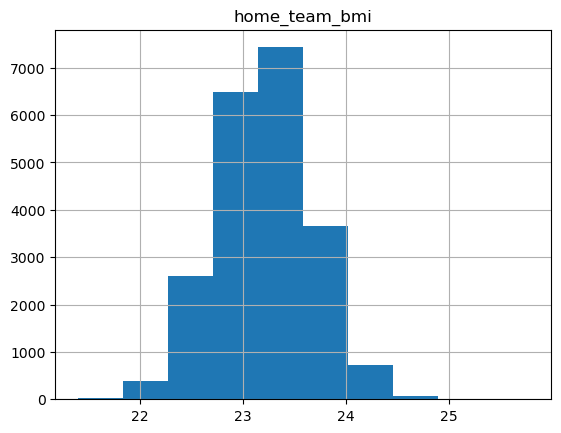

In [30]:
hist_home_team_bmi = df_main_nn.hist(column='home_team_bmi', bins=10)

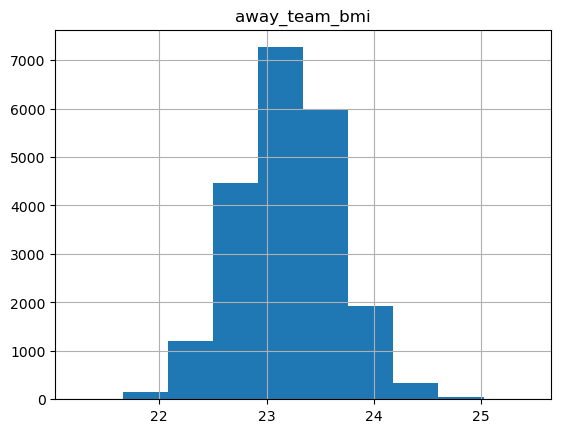

In [31]:
hist_away_team_bmi = df_main_nn.hist(column='away_team_bmi', bins=10)

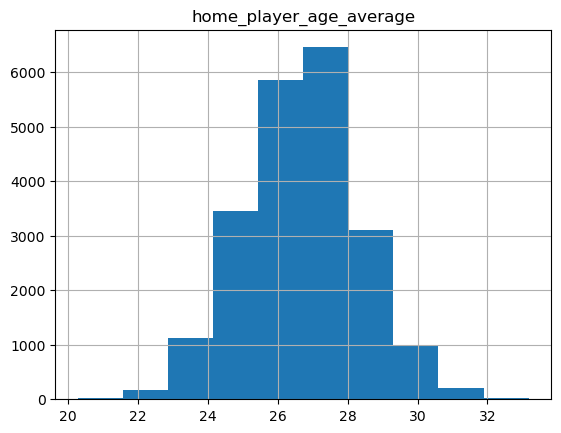

In [32]:
hist_home_player_age_average = df_main_nn.hist(column='home_player_age_average', bins=10)

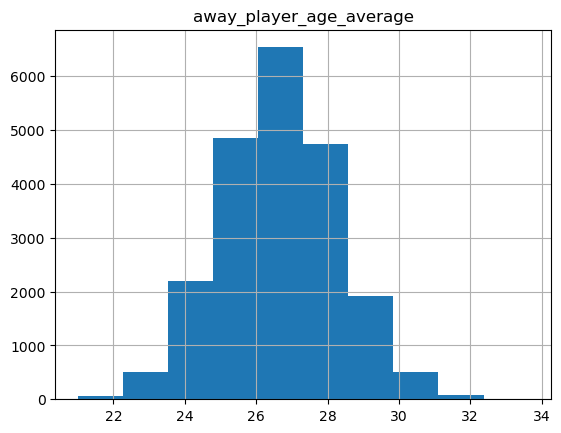

In [33]:
hist_away_player_age_average = df_main_nn.hist(column='away_player_age_average', bins=10)

In [34]:
count_home_team_win = df_main_nn['outcome'].value_counts()[True]
count_home_team_not_win = df_main_nn['outcome'].value_counts()[False]
game_sum = count_home_team_win + count_home_team_not_win 
print("Home team win count")
print(count_home_team_win)
print("\nHome team no win count")
print(count_home_team_not_win)
print("\nActual win percentage for home team")
print((count_home_team_win / game_sum )* 100)

Home team win count
9810

Home team no win count
11564

Actual win percentage for home team
45.89688406475157


In [35]:
# Create the dataframe for modeling
X = df_main_nn[["home_team_bmi", "away_team_bmi", "home_player_age_average", "away_player_age_average"]].values
y = df_main_nn['outcome'].values

X_train,X_test,y_train,y_test = train_test_split(X,y)

In [36]:
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()

decision_tree.fit(X_train, y_train)
random_forest.fit(X_train, y_train)

print(decision_tree.score(X_test, y_test))
print(random_forest.score(X_test, y_test))


0.500561377245509
0.5093562874251497


In [37]:
# always run this at connecting
conn.close()